In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import kornia 
import cv2
from scipy.spatial.distance import cdist
from skimage.transform import warp, ProjectiveTransform
from plot_inlier_matches import *

In [3]:
#load both images and convert to grayscale
left = plt.imread('Glendon-Hall-left.jpg')
middle = plt.imread('Glendon-Hall-middle.jpg')
right = plt.imread('Glendon-Hall-right.jpg')

gray_left = cv2.cvtColor(left, cv2.COLOR_RGB2GRAY)
gray_middle = cv2.cvtColor(middle, cv2.COLOR_RGB2GRAY)
gray_right = cv2.cvtColor(right, cv2.COLOR_RGB2GRAY)

In [4]:
sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(gray_left, None)
img1_with_keypoints = cv2.drawKeypoints(gray_left, keypoints1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray_middle, None)
img2_with_keypoints = cv2.drawKeypoints(gray_middle, keypoints2, None)
keypoints3, descriptors3 = sift.detectAndCompute(gray_right, None)
img3_with_keypoints = cv2.drawKeypoints(gray_right, keypoints2, None)

### The following method to find matches also didn't work, as it crashed my computer and took too long to run

In [ ]:
match = cv2.BFMatcher()
matches = match.knnMatch(descriptors1,descriptors2,k=2)

In [ ]:
matches

### The following method to find distance between descriptors wouldn't work 
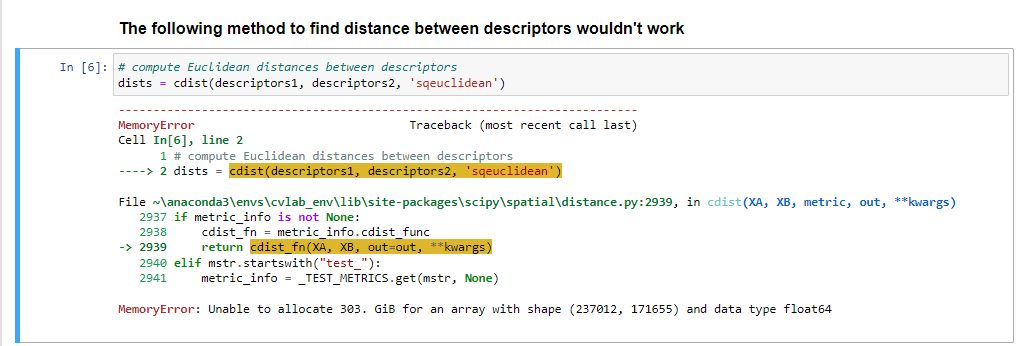

In [6]:
# compute Euclidean distances between descriptors - matches between image left and middle
dists = cdist(descriptors1, descriptors2, 'sqeuclidean')

MemoryError: Unable to allocate 303. GiB for an array with shape (237012, 171655) and data type float64

In [60]:
# select top few hundred descriptor pairs with smallest pairwise distance and extract corresponding keypoints for the inliers
num_pairs = 100
idxs = np.unravel_index(np.argsort(dists, axis=None), dists.shape)
idxs = np.column_stack(idxs)[:num_pairs, :]
kp1 = np.array([keypoints1[idx[0]].pt for idx in idxs])
kp2 = np.array([keypoints2[idx[1]].pt for idx in idxs])
# combine (x,y) coordinates into Nx4 array
inliers = np.hstack((kp1, kp2))

In [ ]:
# find matches between image middle and right

dists = cdist(descriptors2, descriptors3, 'sqeuclidean')
num_pairs = 100
idxs = np.unravel_index(np.argsort(dists, axis=None), dists.shape)
idxs = np.column_stack(idxs)[:num_pairs, :]
kp23 = np.array([keypoints2[idx[0]].pt for idx in idxs])
kp33 = np.array([keypoints3[idx[1]].pt for idx in idxs])
# combine (x,y) coordinates into Nx4 array
inliers = np.hstack((kp23, kp33))

In [ ]:
# assume img1 and img2 are the two images
fig, ax = plt.subplots(figsize=(10, 5))
plot_inlier_matches(ax, gray_left, gray_middle, inliers)
plt.show()

In [ ]:
# Define the corresponding points in each image
pts1 = keypoints1
pts2 = keypoints2
pts3 = keypoints3

# Define the matrix A for img1 and img2
N = len(pts1)
A = np.zeros((2*N, 9))
for i in range(N):
    x1, y1 = pts1[i]
    x2, y2 = pts2[i]
    A[2*i, :] = [-x1, -y1, -1, 0, 0, 0, x1*x2, y1*x2, x2]
    A[2*i+1, :] = [0, 0, 0, -x1, -y1, -1, x1y2, y1y2, y2]
    
U, S, V = np.linalg.svd(A)
h = V[-1, :]
H12 = np.reshape(h, (3, 3))

# between img 2 and img 3 
N = len(pts2)
A = np.zeros((2*N, 9))
for i in range(N):
    x1, y1 = pts2[i]
    x2, y2 = pts3[i]
    A[2*i, :] = [-x1, -y1, -1, 0, 0, 0, x1*x2, y1*x2, x2]
    A[2*i+1, :] = [0, 0, 0, -x1, -y1, -1, x1y2, y1y2, y2]


U, S, V = np.linalg.svd(A)
h = V[-1, :]
H23 = np.reshape(h, (3, 3))  

H13 = np.dot(H23, H12)

In [ ]:
img13 = cv2.warpPerspective(img1, H13, (width, height))
img23 = cv2.warpPerspective(img2, H23, (width, height))
img33 = cv2.warpPerspective(img3, np.identity(3), (width, height))

panorama = cv2.addWeighted(img13, 0.5, img23, 0.5, 0)
panorama = cv2.addWeighted(panorama, 0.5, img33, 0.5, 0)

In [ ]:
plt.imshow(panorama)